# Hyper Parameters

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 200

TRAIN_PERCENTAGE = 0.6
SEQ_LEN = 3

NUM_MLP_LAYERS = 6
MLP_HIDDEN_DIM = 512

D_MODEL = 128
N_HEADS = 8
NUM_TRANSFORMER_LAYERS = 4 
DIM_FEEDFORWARD = 128
DROPOUT_RATE=0.2
LEARNING_RATE = 0.001

# All Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt

# Utils Functions

In [ ]:
def get_country_from_coordinates(lat, lon, country_df):
    for _, row in country_df.iterrows():
        if pd.isna(row['latitude']) or pd.isna(row['longitude']) or pd.isna(row['radius']):
            continue

        dlat = lat - row['latitude']
        dlon = lon - row['longitude']
        distance_deg = np.sqrt(dlat ** 2 + dlon ** 2)

        if distance_deg <= row['radius']:
            return row['country']

    return "Unknown Location"


def add_country_to_df(df, countries_df, lat_col_name='latitude', lon_col_name='longitude'):
    latitudes = df[lat_col_name].to_numpy()
    longitudes = df[lon_col_name].to_numpy()

    country_lats = countries_df['latitude'].to_numpy()
    country_lons = countries_df['longitude'].to_numpy()
    country_radii = countries_df['radius'].to_numpy()
    country_names = countries_df['country'].to_numpy()

    result = np.full(latitudes.shape, 'Unknown Location', dtype=object)

    for i in range(len(countries_df)):
        dlat = latitudes - country_lats[i]
        dlon = longitudes - country_lons[i]
        distances = np.sqrt(dlat ** 2 + dlon ** 2)

        within_radius = (distances <= country_radii[i]) & (result == 'Unknown Location')

        result[within_radius] = country_names[i]

    df['Country'] = result

    df = df.drop([lat_col_name, lon_col_name], axis=1)
    if 'year' in df.columns:
        df = df.rename(columns={'year': 'Year'})

    return df


def one_hot_encode_keep_original(df, column_name, insert_after_col):
    # Create dummy variables
    dummies = pd.get_dummies(df[column_name], prefix=column_name, dtype=float)

    # Find the position to insert the dummies
    col_index = df.columns.get_loc(insert_after_col)

    # Split df into 3 parts: before, the column, after
    before = df.iloc[:, :col_index + 1]
    after = df.iloc[:, col_index + 1:]

    # Concatenate: before + dummies + after
    df_new = pd.concat([before, dummies, after], axis=1)

    return df_new

# Read Data Functions

In [ ]:
def read_countries_data():
    country_df = pd.read_csv('data/country_latitude_longitude_area_lookup.csv')
    country_df.columns = ['latitude', 'longitude', 'country', 'area', 'radius']
    return country_df


def read_and_reformat_yield_and_production_df():
    yield_df = pd.read_csv('data/Yield_and_Production_data.csv')
    combined_data = {}

    for _, row in yield_df.iterrows():
        country_year_key = f"{row['Country']}_{row['Year']}"

        if country_year_key not in combined_data:
            combined_data[country_year_key] = {
                'Country': row['Country'],
                'Year': row['Year']
            }

        item_element_key = f"{row['Item']}_{row['Element']}"
        combined_data[country_year_key][item_element_key] = row['Value']

    combined_df = pd.DataFrame(combined_data.values())

    sorted_columns = list(combined_df.columns)[:2] + sorted(list(combined_df.columns)[2:])
    combined_df = combined_df[sorted_columns]

    return combined_df


def read_canopint_inst_data(countries_df):
    df = pd.read_csv('data/CanopInt_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_esoil_tavg_data(countries_df):
    df = pd.read_csv('data/ESoil_tavg_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_land_cover_data(countries_df):
    df = pd.read_csv('data/Land_cover_percent_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_rainf_tavg_data(countries_df):
    df = pd.read_csv("data/Rainf_tavg_data.csv")
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_snowf_tavg_data(countries_df):
    df = pd.read_csv('data/Snowf_tavg_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soilmoi_inst_0_10_data(countries_df):
    df = pd.read_csv('data/SoilMoi0_10cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soilmoi_inst_10_40_data(countries_df):
    df = pd.read_csv('data/SoilMoi10_40cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soilmoi_inst_40_100_data(countries_df):
    df = pd.read_csv('data/SoilMoi40_100cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soilmoi_inst_100_200_data(countries_df):
    df = pd.read_csv('data/SoilMoi100_200cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soiltmp_inst_0_10_data(countries_df):
    df = pd.read_csv('data/SoilTMP0_10cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soiltmp_inst_10_40_data(countries_df):
    df = pd.read_csv("data/SoilTMP10_40cm_inst_data.csv")
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soiltmp_inst_40_100_data(countries_df):
    df = pd.read_csv('data/SoilTMP40_100cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_soiltmp_inst_100_200_data(countries_df):
    df = pd.read_csv('data/SoilTMP100_200cm_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_tveg_tavg_data(countries_df):
    df = pd.read_csv('data/TVeg_tavg_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


def read_tws_inst_data(countries_df):
    df = pd.read_csv('data/TWS_inst_data.csv')
    df_with_country = add_country_to_df(df, countries_df)
    grouped_df = df_with_country.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()
    return grouped_df


# Preprocess Functions

In [ ]:
def merge_data(
        yield_df,
        canopint_df,
        esoil_df,
        land_df,
        rainf_df,
        snowf_df,
        soilmoi_0_10_df,
        soilmoi_10_40_df,
        soilmoi_40_100_df,
        soilmoi_100_200_df,
        soiltmp_0_10_df,
        soiltmp_10_40_df,
        soiltmp_40_100_df,
        soiltmp_100_200_df,
        tveg_df,
        tws_df
):
    df = yield_df.copy()

    df = pd.merge(df, canopint_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, esoil_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, land_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, rainf_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, snowf_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soilmoi_0_10_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soilmoi_10_40_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soilmoi_40_100_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soilmoi_100_200_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soiltmp_0_10_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soiltmp_10_40_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soiltmp_40_100_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, soiltmp_100_200_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, tveg_df, on=['Country', 'Year'], how='left')
    df = pd.merge(df, tws_df, on=['Country', 'Year'], how='left')

    return df


def scale_data(merged_df):
    exclude_cols = ['Country', 'Year']
    yield_cols = [col for col in merged_df.columns if col.endswith('_Yield')]
    other_cols = [col for col in merged_df.columns if col not in exclude_cols + yield_cols]

    df_scaled = merged_df.copy()

    other_scaler = MinMaxScaler()
    yield_scaler = MinMaxScaler()

    df_scaled[other_cols] = other_scaler.fit_transform(df_scaled[other_cols])
    df_scaled[yield_cols] = yield_scaler.fit_transform(df_scaled[yield_cols])

    scalers = {
        'yield_scaler': yield_scaler,
        'feature_scaler': other_scaler,
    }

    return df_scaled, scalers


def unscale_data(scaled_array, scaler):
    unscaled_array = scaler.inverse_transform(scaled_array)
    return unscaled_array


def impute_data(scaled_df):
    product_cols = [
        col
        for col in scaled_df.columns
        if col.endswith('_Yield') or col.endswith('_Production')
    ]
    scaled_df[product_cols] = scaled_df.groupby('Country')[product_cols].transform(
        lambda group: group.fillna(group.mean()))
    scaled_df[product_cols] = scaled_df[product_cols].fillna(0)

    supporting_cols = [
        col
        for col in scaled_df.columns
        if col not in {'Country', 'Year'} and not col.endswith('_Yield') and not col.endswith('_Production')
    ]
    scaled_df[supporting_cols] = scaled_df[supporting_cols].interpolate(method='linear', axis=0)
    return scaled_df


def add_encoded_columns(imputed_df):
    encoded_df = one_hot_encode_keep_original(imputed_df, 'Country', 'Year')
    return encoded_df

# Dataset Functions

In [ ]:
class CropYieldDataset(Dataset):
    def __init__(self, data_df, is_train, seq_len=3, train_percentage=0.7):
        self.seq_len = seq_len
        self.is_train = is_train
        self.train_percentage = train_percentage
        self.data_cols = [col for col in data_df.columns if col not in {'Country', 'Year'}]
        self.label_cols = [col for col in data_df.columns if col.endswith('_Yield')]
        self.data_items = []
        self._populate_data(data_df)

    def _populate_data(self, data_df):
        country_groups = data_df.groupby('Country')

        for country, country_group in country_groups:
            group_sequences = []
            group_len = len(country_group)

            for start_idx in range(0, group_len - self.seq_len):
                data_rows = country_group.iloc[start_idx: start_idx + self.seq_len][self.data_cols].to_numpy()
                label_rows = country_group.iloc[start_idx + self.seq_len][self.label_cols].to_numpy()
                group_sequences.append((data_rows.astype(np.float32), label_rows.astype(np.float32)))

            train_set_len = int(len(group_sequences) * self.train_percentage)
            self.data_items.extend(
                group_sequences[:train_set_len] if self.is_train else group_sequences[train_set_len:]
            )

    def __len__(self):
        return len(self.data_items)

    def __getitem__(self, idx):
        data, label = self.data_items[idx]
        return torch.tensor(data), torch.tensor(label)


class CropYieldDatasetSimple(CropYieldDataset):
    def __getitem__(self, idx):
        data, label = self.data_items[idx]
        return torch.flatten(torch.tensor(data)), torch.tensor(label)


def get_countries_and_years(data_df, seq_len, train_percentage=0.7):
    country_and_years = []
    country_groups = data_df.groupby('Country')

    for country, country_group in country_groups:
        group_len = len(country_group)
        num_sequences = group_len - seq_len
        num_valid_sequences = num_sequences - int(train_percentage * num_sequences)

        tail_rows = country_group.tail(num_valid_sequences)[['Country', 'Year']]
        country_and_years.extend(tail_rows.values.tolist())

    return country_and_years


# Predict Function

In [ ]:
def predict_mlp(model, valid_dataloader, yield_scaler, data_df, seq_len, train_percentage, criterion):
    model.eval()
    predictions = []

    total_loss = 0.0

    for x_batch, y_batch in valid_dataloader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        predictions.append(y_pred.detach().numpy())
        total_loss += loss.item()

    valid_loss = total_loss / len(valid_dataloader)

    predictions_array = np.vstack(predictions)
    unscaled = unscale_data(predictions_array, yield_scaler)
    unscaled = np.clip(unscaled, 0, None)

    countries_and_years = get_countries_and_years(data_df, seq_len, train_percentage)
    yield_cols = [col for col in data_df.columns if col.endswith('_Yield')]

    result_df = pd.DataFrame(countries_and_years, columns=['Country', 'Year'])
    yield_df = pd.DataFrame(unscaled, columns=yield_cols)

    final_df = pd.concat([result_df, yield_df], axis=1)
    return final_df, valid_loss


# MLP Model

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, num_layers, hidden_dim, input_size, output_size):
        super(MLPModel, self).__init__()

        layers = [
            nn.Linear(input_size, hidden_dim)
        ]

        for _ in range(num_layers - 2):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_dim, hidden_dim))

        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def train_mlp_model(data_df, train_percentage, yield_scaler, num_layers, hidden_dim, seq_len=3, learning_rate=0.001):
    train_dataset_simple = CropYieldDatasetSimple(
        data_df, is_train=True, seq_len=seq_len, train_percentage=train_percentage
    )
    valid_dataset_simple = CropYieldDatasetSimple(
        data_df, is_train=False, seq_len=seq_len, train_percentage=train_percentage
    )

    train_dataloader = DataLoader(train_dataset_simple, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset_simple, batch_size=BATCH_SIZE, shuffle=False)

    input_size = train_dataset_simple[0][0].shape[0]
    output_size = valid_dataset_simple[0][1].shape[0]

    model = MLPModel(num_layers=num_layers, hidden_dim=hidden_dim, input_size=input_size, output_size=output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []

    best_val_loss = float('inf')
    patience = 10
    counter = 0

    best_model_state = model.state_dict()

    for epoch in range(N_EPOCHS):
        epoch_train_loss = 0.0

        model.train()
        for x_batch, y_batch in train_dataloader:
            y_pred = model(x_batch)
            train_loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        epoch_train_loss /= len(train_dataloader)

        epoch_valid_loss = 0.0

        model.eval()
        for x_batch, y_batch in valid_dataloader:
            y_pred = model(x_batch)
            valid_loss = criterion(y_pred, y_batch)

            epoch_valid_loss += valid_loss.item()

        epoch_valid_loss /= len(valid_dataloader)

        print(f"Epoch {epoch}, Train loss: {epoch_train_loss:.4f}, Valid loss: {epoch_valid_loss:.4f}")

        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1

            if counter >= patience:
                print(f"Early stopping triggered, best loss {best_val_loss:.4f}")
                break

        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

    model.load_state_dict(best_model_state)

    predictions, pred_loss = predict_mlp(model, valid_dataloader, yield_scaler, data_df, seq_len, train_percentage, criterion)

    return model, predictions, train_losses, valid_losses, pred_loss


# Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))

    def forward(self, x):
        return x + self.positional_embedding


class CropTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, d_model=128, nhead=4, num_layers=2, dim_feedforward=256,
                 dropout=0.1):
        super(CropTransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, output_dim)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        out = self.fc_out(x)
        return out


def train_transformer_model(data_df, train_percentage, yield_scaler, seq_len=3,
                            d_model=128, nhead=4, num_layers=2, dim_feedforward=256,
                            learning_rate=0.001, dropout=0.1):
    train_dataset = CropYieldDataset(data_df, is_train=True, seq_len=seq_len, train_percentage=train_percentage)
    valid_dataset = CropYieldDataset(data_df, is_train=False, seq_len=seq_len, train_percentage=train_percentage)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

    input_dim = train_dataset[0][0].shape[1]
    output_dim = train_dataset[0][1].shape[0]

    model = CropTransformerModel(input_dim, output_dim, seq_len, d_model=d_model, nhead=nhead, num_layers=num_layers,
                                 dim_feedforward=dim_feedforward, dropout=dropout)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    best_model_state = model.state_dict()

    for epoch in range(N_EPOCHS):
        epoch_train_loss = 0.0
        model.train()
        for x_batch, y_batch in train_dataloader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_dataloader)

        epoch_valid_loss = 0.0
        model.eval()
        for x_batch, y_batch in valid_dataloader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_valid_loss += loss.item()

        epoch_valid_loss /= len(valid_dataloader)

        print(f"Epoch {epoch}, Train loss: {epoch_train_loss:.4f}, Valid loss: {epoch_valid_loss:.4f}")

        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}, best loss {best_val_loss:.4f}")
                break

        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

    model.load_state_dict(best_model_state)

    predictions, pred_loss = predict_mlp(model, valid_dataloader, yield_scaler, data_df, seq_len, train_percentage, criterion)

    return model, predictions, train_losses, valid_losses, pred_loss


# Plot Functions

In [ ]:
def plot_losses(train_losses, valid_losses, figname=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(valid_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if figname is not None:
        plt.savefig(figname)

    plt.show()


def plot_crop_yield_predictions(predicted_df, true_df, min_data_points=5, figname=None):
    crop_names = [col.removesuffix("_Yield") for col in predicted_df.columns.tolist()[2:]]

    # Identify valid (country, crop) pairs based on data availability in true_df
    valid_pairs = []
    for country in true_df['Country'].unique():
        country_data = true_df[true_df['Country'] == country]
        for crop in crop_names:
            crop_col = f"{crop}_Yield"
            if crop_col in country_data.columns:
                num_valid = country_data[crop_col].notna().sum()
                if num_valid >= min_data_points:
                    valid_pairs.append((country, crop))

    if len(valid_pairs) < 4:
        raise ValueError("Not enough valid (country, crop) pairs with sufficient data.")

    selected_pairs = random.sample(valid_pairs, 4)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
    axs = axs.flatten()

    for i, (country, crop) in enumerate(selected_pairs):
        crop_col = f"{crop}_Yield"

        country_pred = predicted_df[predicted_df['Country'] == country]
        country_true = true_df[true_df['Country'] == country]

        merged = country_pred[['Year', crop_col]].merge(
            country_true[['Year', crop_col]],
            on='Year',
            suffixes=('_pred', '_true')
        ).dropna().sort_values('Year')

        axs[i].plot(merged['Year'], merged[f"{crop}_Yield_pred"], label='Predicted', marker='o')
        axs[i].plot(merged['Year'], merged[f"{crop}_Yield_true"], label='Actual', marker='x')
        axs[i].set_title(f"{country} - {crop}")
        axs[i].set_xlabel("Year")
        axs[i].set_ylabel("Yield")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()

    if figname is not None:
        plt.savefig(figname)

    plt.show()

# Read Data Files

In [2]:
countries_df = read_countries_data()

In [43]:
len(countries_df)

245

In [3]:
canopint_df = read_canopint_inst_data(countries_df)

In [4]:
esoil_df = read_esoil_tavg_data(countries_df)

In [5]:
land_df = read_land_cover_data(countries_df)

In [6]:
rainf_df = read_rainf_tavg_data(countries_df)

In [7]:
snowf_df = read_snowf_tavg_data(countries_df)

In [8]:
soilmoi_0_10_df = read_soilmoi_inst_0_10_data(countries_df)

In [9]:
soilmoi_10_40_df = read_soilmoi_inst_10_40_data(countries_df)

In [10]:
soilmoi_40_100_df = read_soilmoi_inst_40_100_data(countries_df)

In [11]:
soilmoi_100_200_df = read_soilmoi_inst_100_200_data(countries_df)

In [12]:
soiltmp_0_10_df = read_soiltmp_inst_0_10_data(countries_df)

In [13]:
soiltmp_10_40_df = read_soiltmp_inst_10_40_data(countries_df)

In [14]:
soiltmp_40_100_df = read_soiltmp_inst_40_100_data(countries_df)

In [15]:
soiltmp_100_200_df = read_soiltmp_inst_100_200_data(countries_df)

In [16]:
tveg_df = read_tveg_tavg_data(countries_df)

In [17]:
tws_df = read_tws_inst_data(countries_df)

In [18]:
yield_df = read_and_reformat_yield_and_production_df()

In [47]:
len(yield_df)

2598

# Merge all dataframes to a combined dataframe

In [19]:
merged_df = merge_data(yield_df,
        canopint_df,
        esoil_df,
        land_df,
        rainf_df,
        snowf_df,
        soilmoi_0_10_df,
        soilmoi_10_40_df,
        soilmoi_40_100_df,
        soilmoi_100_200_df,
        soiltmp_0_10_df,
        soiltmp_10_40_df,
        soiltmp_40_100_df,
        soiltmp_100_200_df,
        tveg_df,
        tws_df)

In [45]:
merged_df

,Country,Year,"Abaca, manila hemp, raw_Production","Abaca, manila hemp, raw_Yield","Agave fibres, raw, n.e.c._Production","Agave fibres, raw, n.e.c._Yield",Apples_Production,Apples_Yield,Apricots_Production,Apricots_Yield,...,TWS_inst_month_3,TWS_inst_month_4,TWS_inst_month_5,TWS_inst_month_6,TWS_inst_month_7,TWS_inst_month_8,TWS_inst_month_9,TWS_inst_month_10,TWS_inst_month_11,TWS_inst_month_12
0,Afghanistan,2010,NaN,NaN,NaN,NaN,59850.00,7000.0,66560.00,8000.0,...,759.861352,743.674792,736.476132,717.834497,702.031248,726.078780,705.013735,691.161732,682.197120,675.912268
1,Afghanistan,2011,NaN,NaN,NaN,NaN,62041.00,7000.0,67995.24,8172.5,...,760.276268,750.627474,726.716575,703.240420,688.366428,680.940648,684.323994,679.442705,689.426532,701.588537
2,Afghanistan,2012,NaN,NaN,NaN,NaN,70000.00,7651.9,83500.00,10000.0,...,764.304482,778.650883,769.200908,734.146394,707.816572,692.859709,691.398446,683.187323,678.061382,693.919494
3,Afghanistan,2013,NaN,NaN,NaN,NaN,78597.00,7600.5,90000.00,9994.4,...,778.740985,789.578874,770.852303,734.906411,709.162063,703.325991,688.395334,680.865189,693.193135,695.736311
4,Afghanistan,2014,NaN,NaN,NaN,NaN,89403.00,7300.0,90000.00,9994.4,...,766.221191,775.642443,761.338508,732.362605,705.953140,690.562591,682.208695,682.420115,699.586497,697.156828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,Zimbabwe,2018,NaN,NaN,NaN,NaN,6857.66,8924.3,44.39,1977.7,...,963.525767,942.930200,910.854475,889.115083,875.295583,857.427800,842.938667,831.463950,827.089675,857.905483
2594,Zimbabwe,2019,NaN,NaN,NaN,NaN,6862.55,8919.9,44.72,1983.2,...,NaN,853.406875,838.325267,828.130392,819.281092,809.843000,801.751075,795.896583,801.223917,818.651917
2595,Zimbabwe,2020,NaN,NaN,NaN,NaN,6815.73,8906.3,44.94,1993.8,...,878.973658,893.690033,875.554358,855.129225,841.644717,829.535075,820.610100,814.554767,808.559692,845.153825
2596,Zimbabwe,2021,NaN,NaN,NaN,NaN,6820.12,8897.2,44.98,1989.2,...,897.752933,870.585817,855.088467,842.373533,831.639983,821.165892,811.662650,804.893008,803.387550,809.973958


# Preprocess

## Scale Data

In [20]:
scaled_df, scalers = scale_data(merged_df)

# Impute Data

In [21]:
imputed_df = impute_data(scaled_df)

## One Hot Encode Countries

In [22]:
encoded_df = add_encoded_columns(imputed_df)

# Train Sequential MLP Model

In [ ]:
mlp_model, predictions, mlp_train_losses, mlp_valid_losses, mlp_pred_loss = train_mlp_model(encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], NUM_MLP_LAYERS, MLP_HIDDEN_DIM, SEQ_LEN)

In [ ]:
predictions

# Plotting

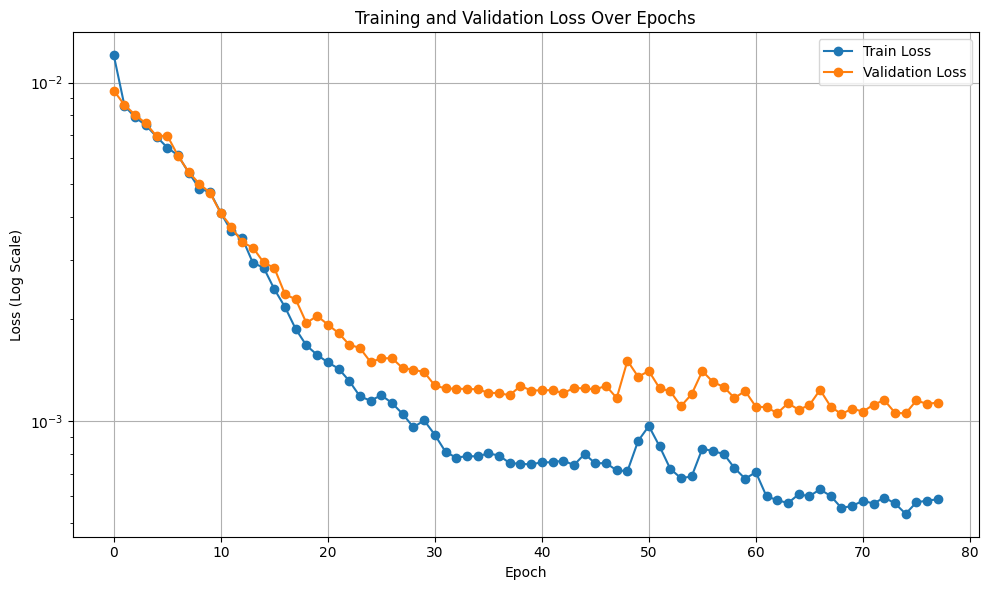

In [25]:
plot_losses(mlp_train_losses, mlp_valid_losses, "plots/mlp_loss_curve.png")

## Plot Random Country - Crop Pairs

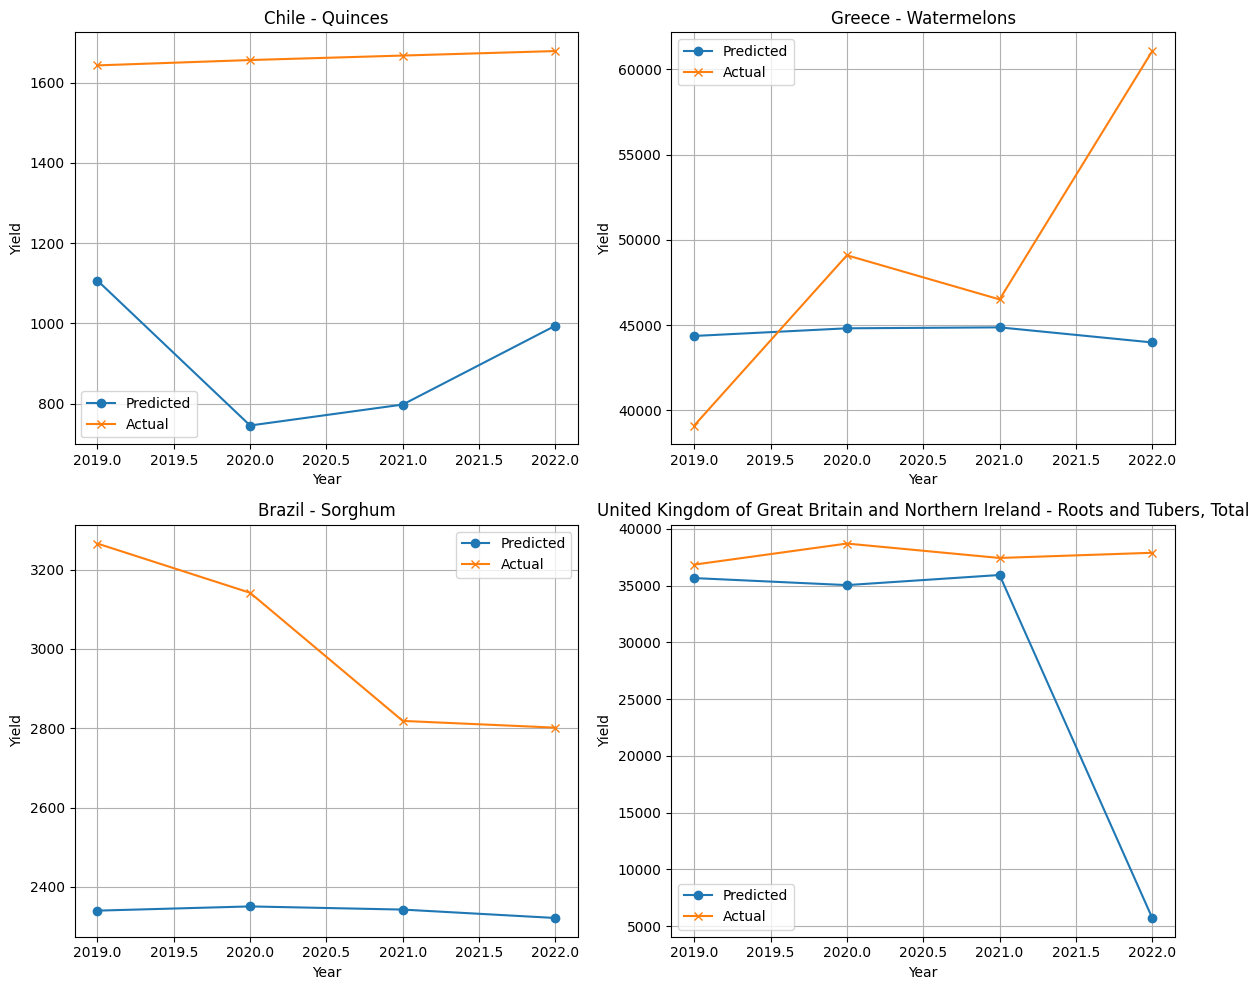

In [27]:
plot_crop_yield_predictions(predictions, merged_df, figname="plots/mlp_predictions.png")

In [28]:
torch.save(mlp_model.state_dict(), 'save/crop_mlp_model.pth')

# Train Transformer Model

In [ ]:
transformer_model, predictions, transformer_train_losses, transformer_valid_losses, transformer_pred_loss = train_transformer_model(
        encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
        d_model=D_MODEL, nhead=N_HEADS, num_layers=NUM_TRANSFORMER_LAYERS,dim_feedforward=DIM_FEEDFORWARD, learning_rate=LEARNING_RATE,
        dropout=DROPOUT_RATE
)

# Plotting

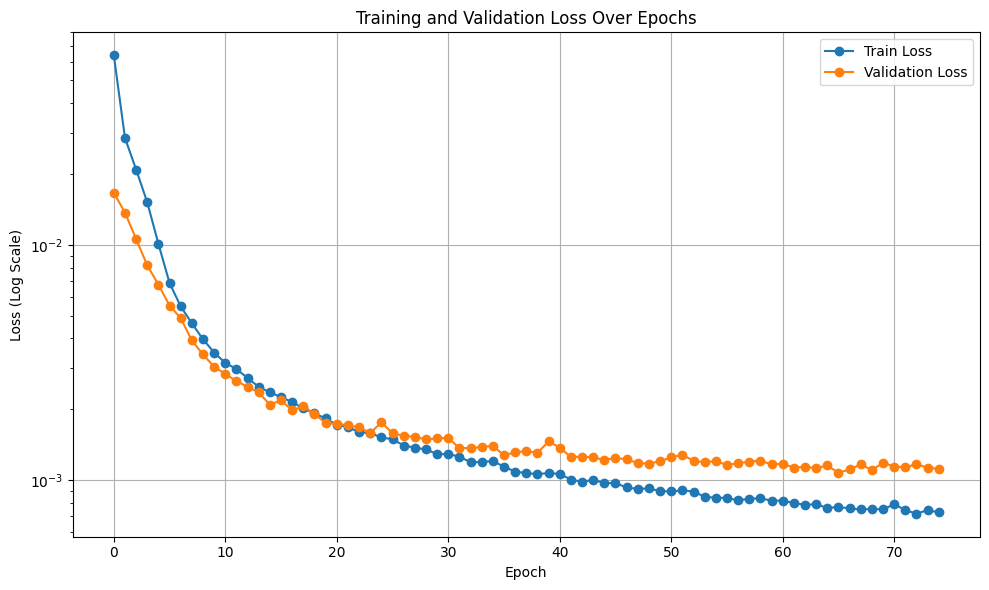

In [31]:
plot_losses(transformer_train_losses, transformer_valid_losses, "plots/transformer_loss_curve.png")

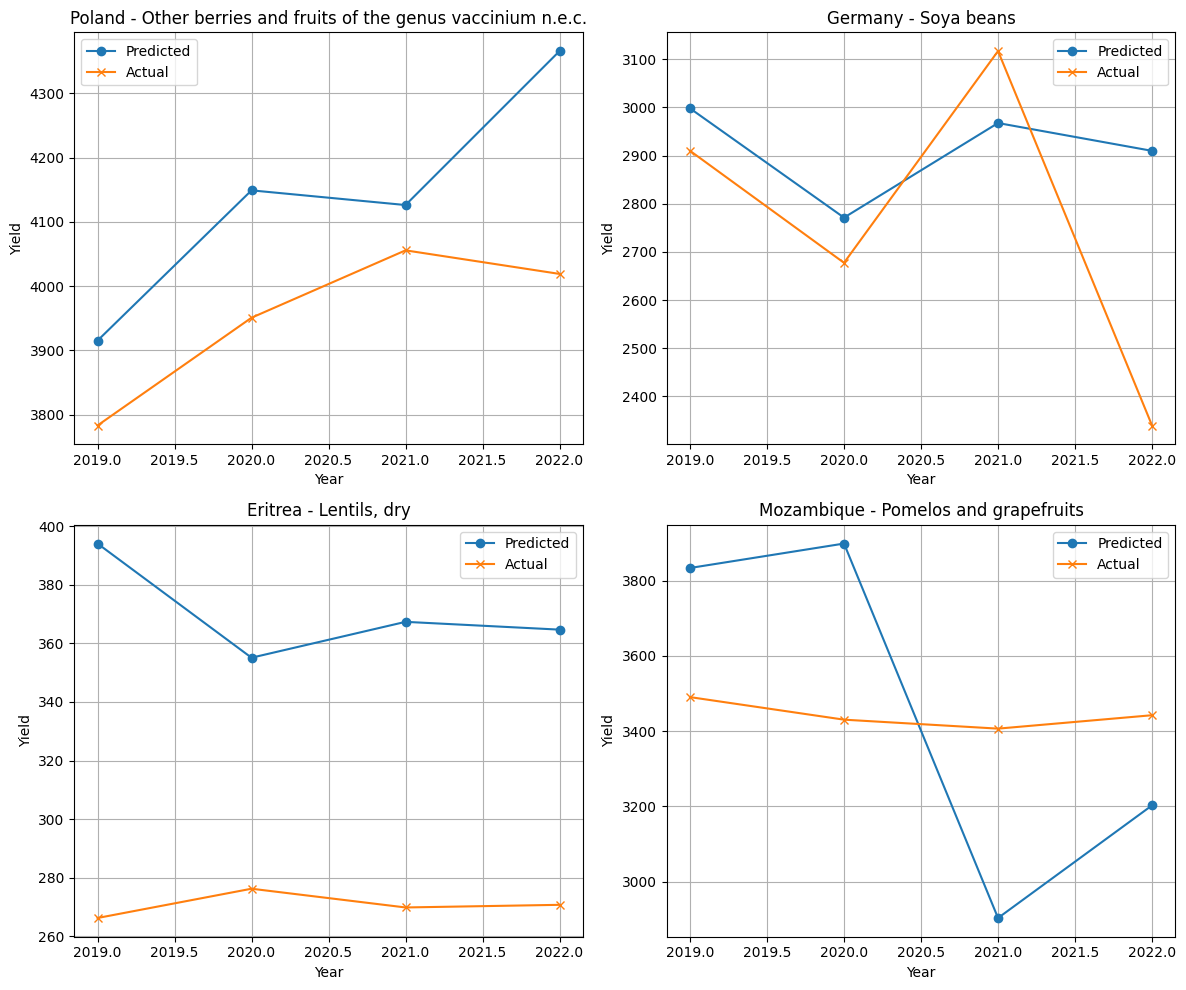

In [32]:
plot_crop_yield_predictions(predictions, merged_df,  figname="plots/transformer_predictions.png")

In [33]:
torch.save(transformer_model.state_dict(), 'save/crop_transformer_model.pth')

# Comparison of MLP and Transformer Model

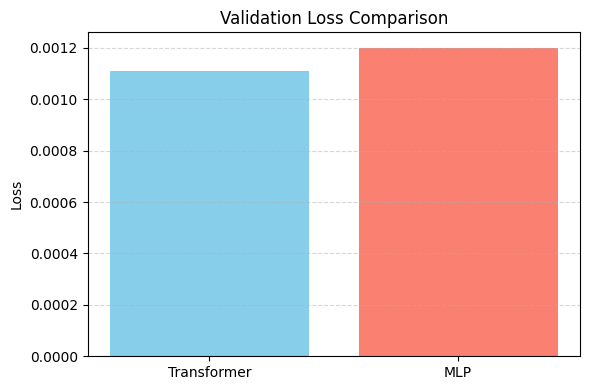

In [34]:
models = ['Transformer', 'MLP']
losses = [transformer_pred_loss, mlp_pred_loss]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, losses, color=['skyblue', 'salmon'])

plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('plots/mlp_vs_transformer_comparison.png')
plt.show()

# Hyperparameter Optimization

In [35]:
d_models = [64, 128, 256, 512]
n_heads = [2, 4, 8]
num_transformer_layers = [1, 2, 4, 6]
dim_feedforwards = [128, 256, 512, 1024]
learning_rates = [10**-i for i in range(2, 7)]
dropout_rates = [0.05, 0.1, 0.2, 0.3]

In [ ]:
d_model_losses = []

for d_model in d_models:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=d_model, nhead=N_HEADS, num_layers=NUM_TRANSFORMER_LAYERS,
                dim_feedforward=DIM_FEEDFORWARD, learning_rate=LEARNING_RATE,
                dropout=DROPOUT_RATE
        )
        d_model_losses.append(pred_loss)

In [ ]:
n_head_losses = []

for n_head in n_heads:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=D_MODEL, nhead=n_head, num_layers=NUM_TRANSFORMER_LAYERS,
                dim_feedforward=DIM_FEEDFORWARD, learning_rate=LEARNING_RATE,
                dropout=DROPOUT_RATE
        )
        n_head_losses.append(pred_loss)

In [ ]:
num_transformer_layer_losses = []

for num_transformer_layer in num_transformer_layers:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=D_MODEL, nhead=N_HEADS, num_layers=num_transformer_layer,
                dim_feedforward=DIM_FEEDFORWARD, learning_rate=LEARNING_RATE,
                dropout=DROPOUT_RATE
        )
        num_transformer_layer_losses.append(pred_loss)

In [ ]:
dim_feedforward_losses = []

for dim_feedforward in dim_feedforwards:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=D_MODEL, nhead=N_HEADS, num_layers=NUM_TRANSFORMER_LAYERS,
                dim_feedforward=dim_feedforward, learning_rate=LEARNING_RATE,
                dropout=DROPOUT_RATE
        )
        dim_feedforward_losses.append(pred_loss)

In [ ]:
learning_rate_losses = []

for learning_rate in learning_rates:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=D_MODEL, nhead=N_HEADS, num_layers=NUM_TRANSFORMER_LAYERS,
                dim_feedforward=DIM_FEEDFORWARD, learning_rate=learning_rate,
                dropout=DROPOUT_RATE
        )
        learning_rate_losses.append(pred_loss)

In [ ]:
dropout_rate_losses = []

for dropout_rate in dropout_rates:
        _, _, _, _, pred_loss = train_transformer_model(
                encoded_df, TRAIN_PERCENTAGE, scalers['yield_scaler'], seq_len=SEQ_LEN,
                d_model=D_MODEL, nhead=N_HEADS, num_layers=NUM_TRANSFORMER_LAYERS,
                dim_feedforward=DIM_FEEDFORWARD, learning_rate=LEARNING_RATE,
                dropout=dropout_rate
        )
        dropout_rate_losses.append(pred_loss)

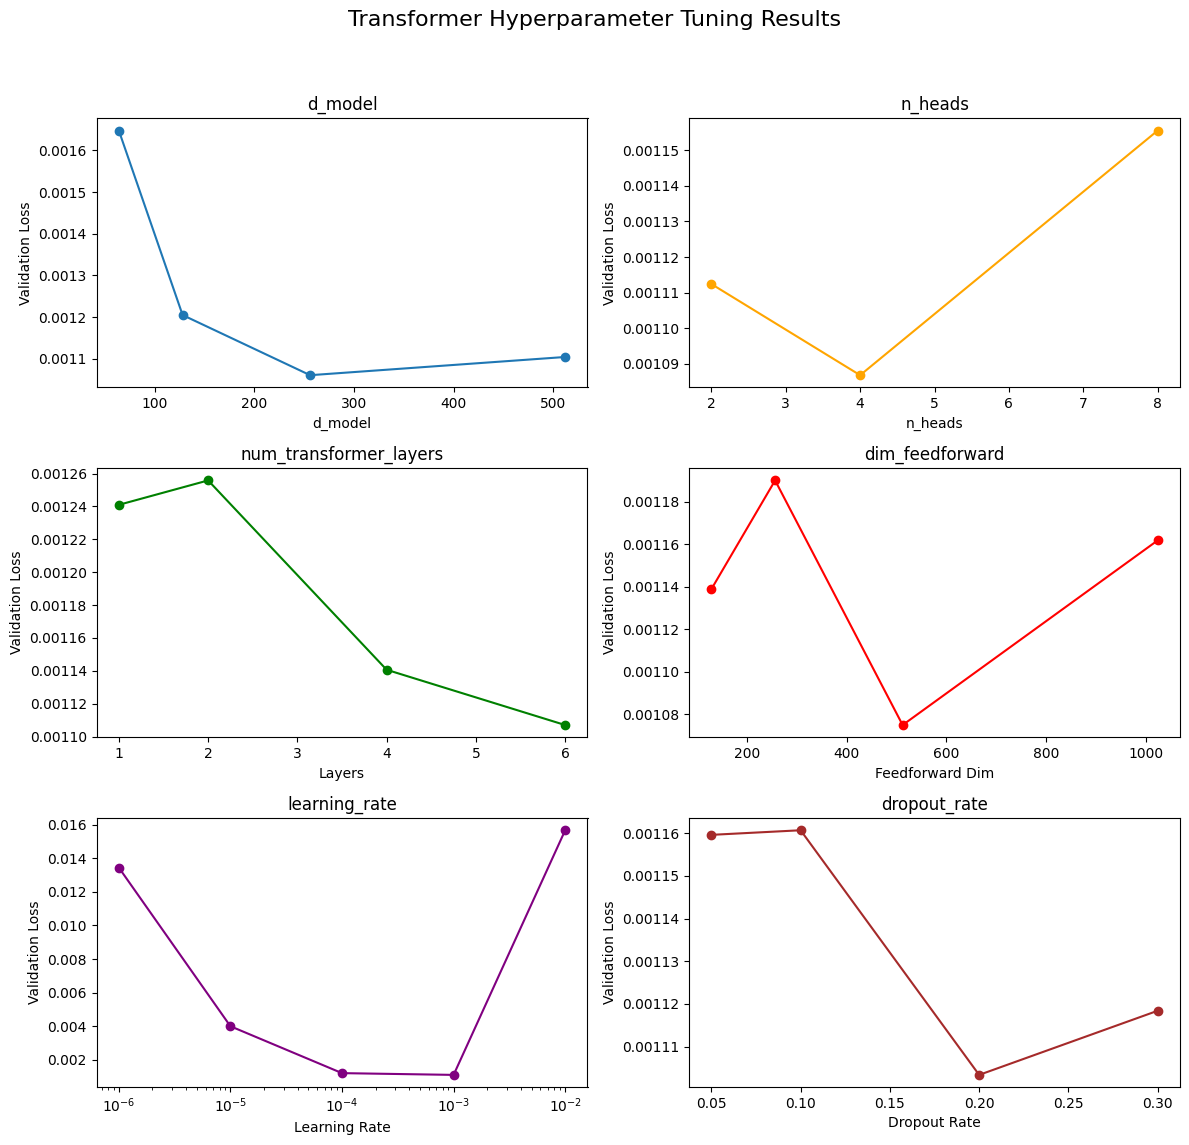

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Transformer Hyperparameter Tuning Results', fontsize=16)

# Plot d_model
axes[0, 0].plot(d_models, d_model_losses, marker='o')
axes[0, 0].set_title('d_model')
axes[0, 0].set_xlabel('d_model')
axes[0, 0].set_ylabel('Validation Loss')

# Plot n_heads
axes[0, 1].plot(n_heads, n_head_losses, marker='o', color='orange')
axes[0, 1].set_title('n_heads')
axes[0, 1].set_xlabel('n_heads')
axes[0, 1].set_ylabel('Validation Loss')

# Plot num_transformer_layers
axes[1, 0].plot(num_transformer_layers, num_transformer_layer_losses, marker='o', color='green')
axes[1, 0].set_title('num_transformer_layers')
axes[1, 0].set_xlabel('Layers')
axes[1, 0].set_ylabel('Validation Loss')

# Plot dim_feedforward
axes[1, 1].plot(dim_feedforwards, dim_feedforward_losses, marker='o', color='red')
axes[1, 1].set_title('dim_feedforward')
axes[1, 1].set_xlabel('Feedforward Dim')
axes[1, 1].set_ylabel('Validation Loss')

# Plot learning_rate
axes[2, 0].plot(learning_rates, learning_rate_losses, marker='o', color='purple')
axes[2, 0].set_title('learning_rate')
axes[2, 0].set_xscale('log')
axes[2, 0].set_xlabel('Learning Rate')
axes[2, 0].set_ylabel('Validation Loss')

# Plot dropout_rate
axes[2, 1].plot(dropout_rates, dropout_rate_losses, marker='o', color='brown')
axes[2, 1].set_title('dropout_rate')
axes[2, 1].set_xlabel('Dropout Rate')
axes[2, 1].set_ylabel('Validation Loss')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('plots/hyperparameter_optimization.png')
plt.show()